In [ ]:
!python3 -m pip install spacy==3.7.4

In [2]:
!mkdir data 
!wget -P data https://raw.githubusercontent.com/PacktPublishing/Mastering-spaCy/main/Chapter06/data/atis_intents.csv 

mkdir: não foi possível criar o diretório “data”: Arquivo existe
--2024-04-19 11:38:25--  https://raw.githubusercontent.com/PacktPublishing/Mastering-spaCy/main/Chapter06/data/atis_intents.csv
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 391936 (383K) [text/plain]
Salvando em: ‘data/atis_intents.csv.2’

atis_intents.csv.2  100%[===================>] 382.75K  --.-KB/s    em 0.1s    

2024-04-19 11:38:26 (3.18 MB/s) - ‘data/atis_intents.csv.2’ salvo [391936/391936]



In [13]:
import pandas as pd 

df = pd.read_csv("data/atis_intents.csv", header=None, names=["utterance", "text"]) 
df.shape 

/tmp/ipykernel_1623911/2283459057.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(4978, 2)

<Axes: ylabel='utterance'>

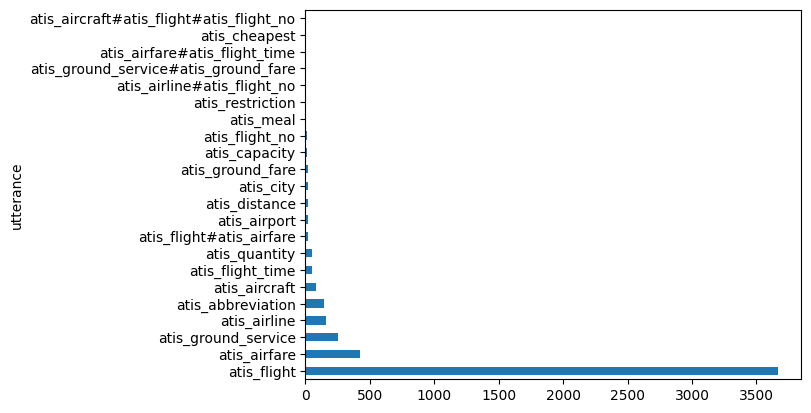

In [4]:
df["utterance"].value_counts().plot.barh() 

In [1]:
import spacy 
from spacy import displacy 

nlp = spacy.load("en_core_web_sm") 
text = "i want to fly from boston at 838 am and arrive in denver at 1110 in the morning" 
doc = nlp(text)  

displacy.render(doc, style='ent') 

/home/deborah/Documents/Code/mastering_spacy_2nd_edition/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
nlp.pipe_names 

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [10]:
spanruler_component = nlp.add_pipe("span_ruler") 
patterns_location_spanruler = [{"label": "LOCATION", "pattern": [{"POS": "ADP"}, {"ENT_TYPE": "GPE"}]}] 
spanruler_component.add_patterns(patterns_location_spanruler) 

In [11]:
doc = nlp(text) 
options = {"spans_key": "ruler"} 
displacy.render(doc, style='span', options=options) 

In [12]:
text = "show me flights from denver to philadelphia on tuesday" 
doc = nlp(text) 
displacy.render(doc, style='dep') 

In [2]:
from spacy.matcher import DependencyMatcher 

matcher = DependencyMatcher(nlp.vocab) 

def show_intent(matcher, doc, i, matches): 
    match_id, token_ids = matches[i] 
    verb_token = doc[token_ids[1]] 
    dobj_token = doc[token_ids[0]] 
    intent = verb_token.lemma_ + dobj_token.lemma_.capitalize() 
    print(f"Intent:", intent)  

pattern = [ 
    { 
        "RIGHT_ID": "direct_object_token", 
        "RIGHT_ATTRS": {"DEP": "dobj"} 
    }, 
    { 
        "LEFT_ID": "direct_object_token", 
        "REL_OP": "<", 
        "RIGHT_ID": "verb_token", 
        "RIGHT_ATTRS": {"POS": "VERB"} 
    } 
] 

matcher.add("INTENT", [pattern], on_match=show_intent) 
doc = nlp("show me flights from denver to philadelphia on tuesday") 
matches = matcher(doc) 

Intent: showFlight


In [3]:
pattern_two = [ 
    { 
        "RIGHT_ID": "direct_object_token", 
        "RIGHT_ATTRS": {"DEP": "dobj"} 
    }, 
    { 
        "LEFT_ID": "direct_object_token", 
        "REL_OP": "<", 
        "RIGHT_ID": "verb_token", 
        "RIGHT_ATTRS": {"POS": "VERB"} 
    }, 
    { 
        "LEFT_ID": "direct_object_token", 
        "REL_OP": ">", 
        "RIGHT_ID": "conjunction_token", 
        "RIGHT_ATTRS": {"DEP": "conj"} 
    } 
] 

def show_two_intents(matcher, doc, i, matches): 
    match_id, token_ids = matches[i] 
    verb_token = doc[token_ids[1]] 
    dobj_token = doc[token_ids[0]] 
    conj_token = doc[token_ids[2]] 
    intent = verb_token.lemma_ + dobj_token.lemma_.capitalize() + ";" + verb_token.lemma_ + conj_token.lemma_.capitalize() 
    print("Two intents:", intent) 

matcher.add("TWO_INTENTS", [pattern_two], on_match=show_two_intents) 
doc = nlp("show all flights and fares from denver to san francisco") 
matches = matcher(doc) 

Intent: showFlight
Two intents showFlight;showFare


In [4]:
text = "show all flights and fares from denver to san francisco" 
doc = nlp(text) 
displacy.render(doc, style='dep') 

In [4]:
from spacy.language import Language
from spacy.tokens import Doc

class IntentComponent: 
    def __init__(self, nlp: Language): 
        self.matcher = DependencyMatcher(nlp.vocab) 

        pattern = [ 
            { 
                "RIGHT_ID": "direct_object_token", 
                "RIGHT_ATTRS": {"DEP": "dobj"} 
            }, 
            { 
                "LEFT_ID": "direct_object_token", 
                "REL_OP": "<", 
                "RIGHT_ID": "verb_token", 
                "RIGHT_ATTRS": {"POS": "VERB"} 
            } 
        ] 

        pattern_two = [ 
            { 
                "RIGHT_ID": "direct_object_token", 
                "RIGHT_ATTRS": {"DEP": "dobj"} 
            }, 
            { 
                "LEFT_ID": "direct_object_token", 
                "REL_OP": "<", 
                "RIGHT_ID": "verb_token", 
                "RIGHT_ATTRS": {"POS": "VERB"} 
            }, 
            { 
                "LEFT_ID": "direct_object_token", 
                "REL_OP": ">", 
                "RIGHT_ID": "conjunction_token", 
                "RIGHT_ATTRS": {"DEP": "conj"} 
            } 
        ] 

        self.matcher.add("INTENT", [pattern]) 
        self.matcher.add("TWO_INTENTS", [pattern_two]) 

        if not Doc.has_extension("intent"): 
            Doc.set_extension("intent", default=None)  

    def __call__(self, doc: Doc) -> Doc: 
        matches = self.matcher(doc)                

        for match_id, token_ids in matches:             
            string_id = nlp.vocab.strings[match_id]
            if string_id == "TWO_INTENTS":
                verb_token = doc[token_ids[1]] 
                dobj_token = doc[token_ids[0]] 
                conj_token = doc[token_ids[2]] 
                intent = verb_token.lemma_ + dobj_token.lemma_.capitalize() + ";" + verb_token.lemma_ + conj_token.lemma_.capitalize() 
                doc._.intent = intent 
                break
        else:
            for match_id, token_ids in matches:   
                string_id = nlp.vocab.strings[match_id]
                if string_id == "INTENT":
                    verb_token = doc[token_ids[1]] 
                    dobj_token = doc[token_ids[0]] 
                    intent = verb_token.lemma_ + dobj_token.lemma_.capitalize()     
                    doc._.intent = intent 
                    
        return doc 

In [5]:
@Language.factory("intent_component") 
def create_intent_component(nlp: Language, name: str): 
    return IntentComponent(nlp) 

In [6]:
nlp.add_pipe("intent_component") 
text = "show all flights and fares from denver to san francisco" 
doc = nlp(text) 
doc._.intent 

'showFlight;showFare'

In [8]:
text = "show me flights from denver to philadelphia on tuesday"
doc = nlp(text) 
doc._.intent 

'showFlight'

In [11]:
text = "no matches"
doc = nlp(text) 
doc._.intent 

In [14]:
import time 

start_time = time.time() 
utterance_texts = df.text.to_list() 
processed_docs_vanilla = [nlp(text) for text in utterance_texts] 
end_time = time.time() 
execution_time = end_time - start_time 
print("Execution time:", execution_time, "seconds") 

Execution time: 27.404495000839233 seconds


In [15]:
import time 

start_time = time.time() 
utterance_texts = df.text.to_list() 
processed_docs_pipe = [nlp.pipe(text) for text in utterance_texts] 
end_time = time.time() 
execution_time = end_time - start_time 
print("Execution time:", execution_time, "seconds") 

Execution time: 0.009811878204345703 seconds
